In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## Data Set Up

In [24]:
# Import Data
us_diff = pd.read_csv('univariate_datasets/us_diff.csv', usecols=[1,2], index_col=0, parse_dates=[0])
us_uni = pd.read_csv('univariate_datasets/univariate_df_United_States.csv',usecols=[1,2], index_col=0, parse_dates=[0])

# test_train split
train_size = int(len(us_uni)*0.8)
us_train, us_test = us_uni[0:train_size], us_uni[train_size:]

ADF Test Statistic : -2.5252838085816958
p-value : 0.10944306442755447
#Lags Used : 7
Number of Observations Used : 194
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None
ADF Test Statistic : -7.154085375650149
p-value : 3.0869768235518104e-10
#Lags Used : 6
Number of Observations Used : 194
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


<Axes: xlabel='date'>

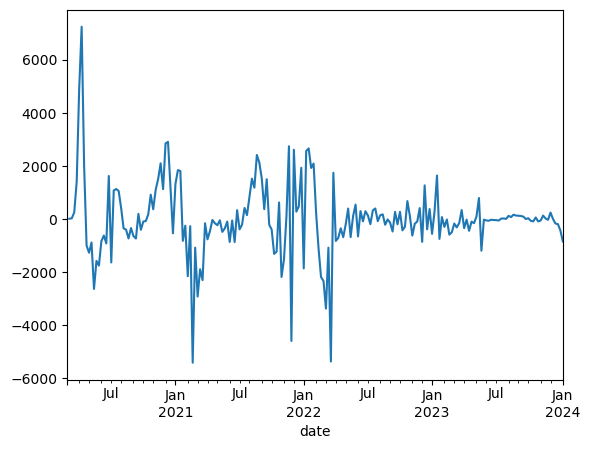

In [4]:
# checking stationarity
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
print(adfuller_test(us_uni['new_deaths']))
print(adfuller_test(us_diff['new_deaths'].dropna()))
us_diff['new_deaths'].plot()

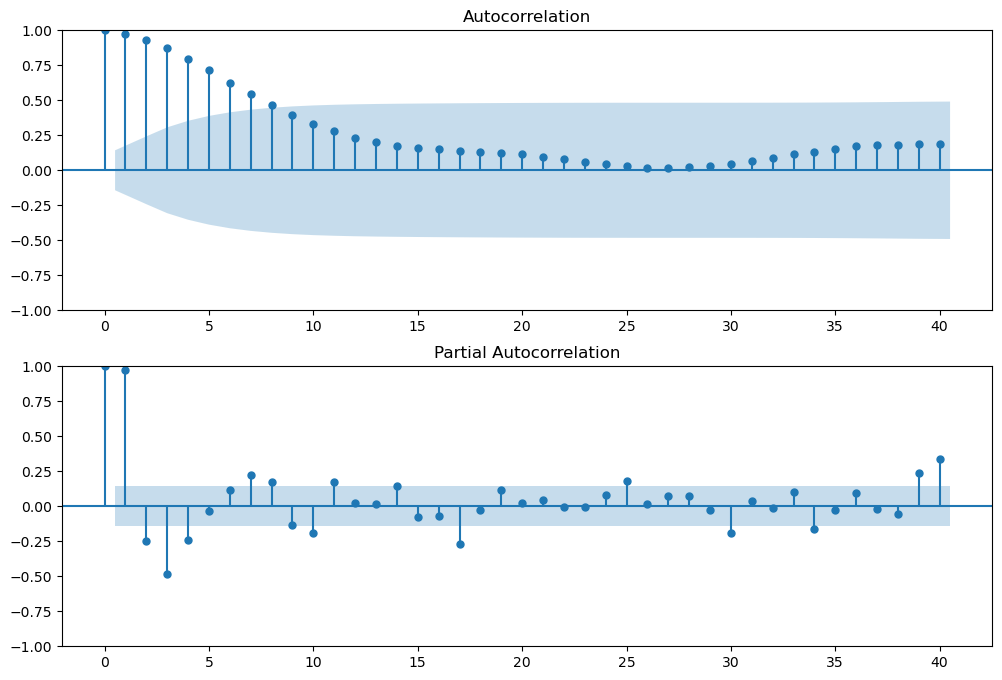

In [20]:
# ACF and PACF plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(us_uni['new_deaths'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(us_uni['new_deaths'].iloc[13:],lags=40,ax=ax2)

# Building ARIMA

In [6]:
# For non-seasonal data, baseline
#p=1, d=1, q=1 
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

model = ARIMA(us_train['new_deaths'], order=(1,1,1))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  202
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1716.528
Date:                Thu, 22 Feb 2024   AIC                           3439.056
Time:                        15:33:13   BIC                           3448.966
Sample:                    03-01-2020   HQIC                          3443.066
                         - 01-07-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7218      0.079      9.102      0.000       0.566       0.877
ma.L1         -0.4064      0.095     -4.274      0.000      -0.593      -0.220
sigma2      1.566e+06    8.3e+04     18.863      0.000     1.4e+06    1.73e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               279.79
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'New Deaths')

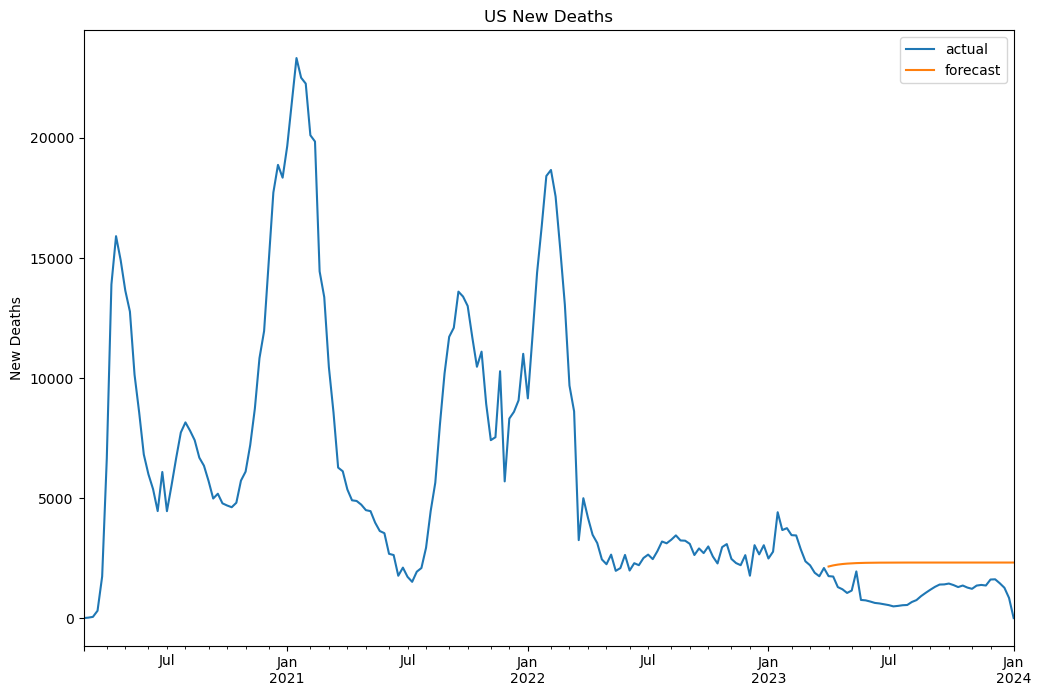

In [8]:
# evaluation 
us_prediction=model_fit.predict(start=train_size,dynamic=True)
df = pd.concat([us_uni['new_deaths'],us_prediction], axis=1)
df.columns = ['actual','forecast']
df.plot(figsize=(12,8))
# plot title and labels
plt.title('US New Deaths')
plt.ylabel('New Deaths')

## Grid Search for p and q 

In [26]:
results = []
for p in range(1,5):
    for q in range(1,5): 
        model = ARIMA(us_train['new_deaths'], order=(p,1,q)).fit()
        results.append([p,q,model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
results_df.sort_values('aic')

,p,q,aic
8,3,1,2760.695665
12,4,1,2761.729031
6,2,3,2761.801169
9,3,2,2764.224333
10,3,3,2764.441508
5,2,2,2766.820785
1,1,2,2767.592021
13,4,2,2767.732277
14,4,3,2768.046407
4,2,1,2768.639997


## The grid search shows that p=3 and q=1 is the best combination for the ARIMA model.

Text(0, 0.5, 'New Deaths')

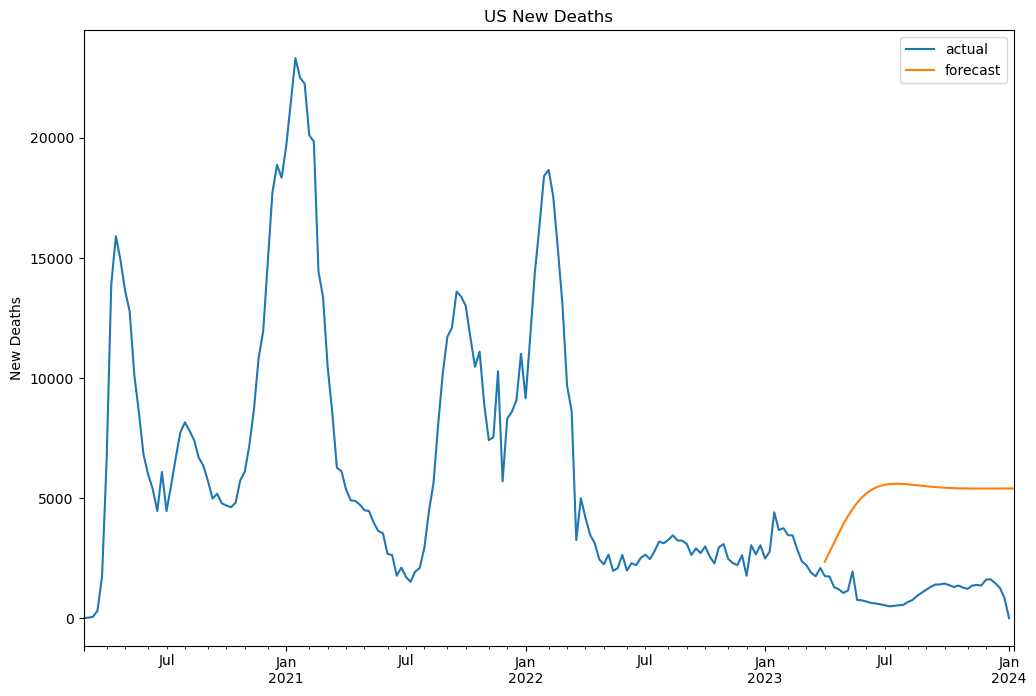

In [34]:
model = ARIMA(us_train['new_deaths'], order=(3,1,1))
model_fit = model.fit()
# evaluation 
us_prediction = model_fit.predict(start=train_size, end=202,dynamic=True)
df = pd.concat([us_uni['new_deaths'],us_prediction], axis=1)
df.columns = ['actual','forecast']
df.plot(figsize=(12,8))
# plot title and labels
plt.title('US New Deaths')
plt.ylabel('New Deaths')



## Seaonality

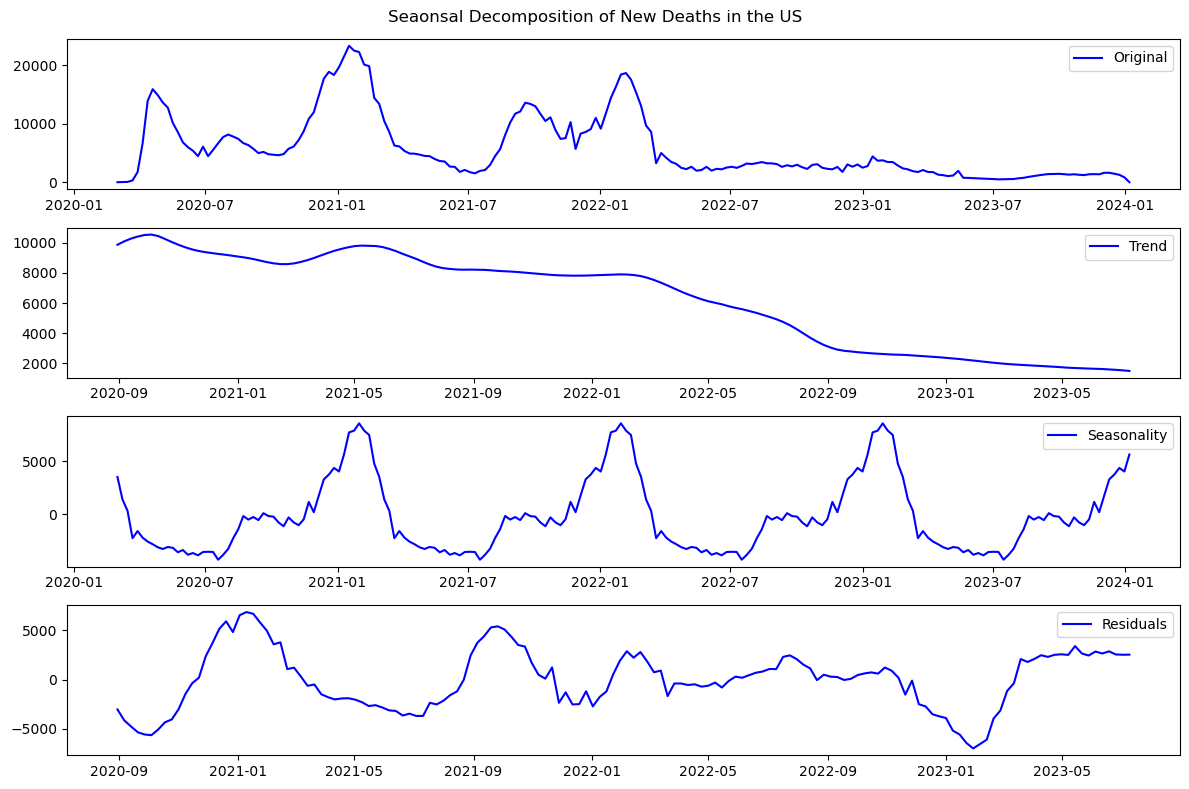

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
decomposition = seasonal_decompose(us_uni, period=52) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(us_uni['new_deaths'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.suptitle('Seaonsal Decomposition of New Deaths in the US')
plt.tight_layout()

In [35]:
# grid search
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10618D+00    |proj g|=  5.68892D-02


 This problem is unconstrained.



At iterate    5    f=  8.07724D+00    |proj g|=  3.41003D-03

At iterate   10    f=  8.07682D+00    |proj g|=  2.39189D-04

At iterate   15    f=  8.07659D+00    |proj g|=  7.02843D-03

At iterate   20    f=  8.04616D+00    |proj g|=  9.88944D-02

At iterate   25    f=  7.97704D+00    |proj g|=  1.89722D-02

At iterate   30    f=  7.96607D+00    |proj g|=  2.22967D-03

At iterate   35    f=  7.96500D+00    |proj g|=  1.49587D-03

At iterate   40    f=  7.96486D+00    |proj g|=  1.00152D-03

At iterate   45    f=  7.96483D+00    |proj g|=  2.03828D-04

At iterate   50    f=  7.96483D+00    |proj g|=  7.81142D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09193D+00    |proj g|=  4.63920D-02

At iterate    5    f=  8.07917D+00    |proj g|=  4.77792D-03

At iterate   10    f=  8.07523D+00    |proj g|=  1.00200D-02

At iterate   15    f=  8.07476D+00    |proj g|=  2.41484D-04

At iterate   20    f=  8.07473D+00    |proj g|=  2.92660D-03

At iterate   25    f=  8.06931D+00    |proj g|=  3.32207D-02

At iterate   30    f=  7.98427D+00    |proj g|=  5.41329D-02

At iterate   35    f=  7.97765D+00    |proj g|=  2.19744D-02

At iterate   40    f=  7.96591D+00    |proj g|=  1.15051D-02

At iterate   45    f=  7.96510D+00    |proj g|=  1.26048D-04

At iterate   50    f=  7.96509D+00    |proj g|=  2.07081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  8.07388D+00    |proj g|=  1.56193D-03

At iterate   15    f=  8.07385D+00    |proj g|=  8.13810D-04

At iterate   20    f=  8.07329D+00    |proj g|=  1.48492D-02

At iterate   25    f=  8.02708D+00    |proj g|=  1.82228D-01

At iterate   30    f=  7.96120D+00    |proj g|=  2.54900D-02

At iterate   35    f=  7.96027D+00    |proj g|=  3.85640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     41      1     0     0   3.154D-06   7.960D+00
  F =   7.9602675730412313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.07392D+00    |proj g|=  4.86893D-03

At iterate   10    f=  8.07299D+00    |proj g|=  7.54208D-04

At iterate   15    f=  8.07289D+00    |proj g|=  1.15664D-03

At iterate   20    f=  8.07288D+00    |proj g|=  6.51698D-04

At iterate   25    f=  8.07268D+00    |proj g|=  7.98905D-03

At iterate   30    f=  8.06087D+00    |proj g|=  2.15905D-02

At iterate   35    f=  7.99247D+00    |proj g|=  2.76091D-02

At iterate   40    f=  7.96189D+00    |proj g|=  1.14805D-02

At iterate   45    f=  7.96114D+00    |proj g|=  1.73134D-02

At iterate   50    f=  7.95944D+00    |proj g|=  3.13177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.98807D+00    |proj g|=  1.77764D-03

At iterate   10    f=  7.98802D+00    |proj g|=  2.22334D-04

At iterate   15    f=  7.98800D+00    |proj g|=  1.59183D-03

At iterate   20    f=  7.98556D+00    |proj g|=  4.09312D-02

At iterate   25    f=  7.93910D+00    |proj g|=  4.23384D-02

At iterate   30    f=  7.92542D+00    |proj g|=  3.59467D-02

At iterate   35    f=  7.92385D+00    |proj g|=  4.89794D-03

At iterate   40    f=  7.92352D+00    |proj g|=  1.40350D-03

At iterate   45    f=  7.92348D+00    |proj g|=  1.16653D-03

At iterate   50    f=  7.92347D+00    |proj g|=  1.13914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.99051D+00    |proj g|=  7.41180D-03

At iterate   10    f=  7.98890D+00    |proj g|=  2.68988D-02

At iterate   15    f=  7.98592D+00    |proj g|=  2.38728D-03

At iterate   20    f=  7.98590D+00    |proj g|=  2.24956D-04

At iterate   25    f=  7.98560D+00    |proj g|=  5.69606D-03

At iterate   30    f=  7.93264D+00    |proj g|=  1.18615D-02

At iterate   35    f=  7.93038D+00    |proj g|=  4.80921D-03

At iterate   40    f=  7.93017D+00    |proj g|=  1.03704D-03

At iterate   45    f=  7.92977D+00    |proj g|=  5.75162D-03

At iterate   50    f=  7.92971D+00    |proj g|=  1.78192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.99223D+00    |proj g|=  6.89601D-02

At iterate   10    f=  7.98526D+00    |proj g|=  8.09845D-04

At iterate   15    f=  7.98525D+00    |proj g|=  2.25800D-04

At iterate   20    f=  7.98518D+00    |proj g|=  4.20581D-03

At iterate   25    f=  7.97680D+00    |proj g|=  4.65648D-02

At iterate   30    f=  7.93501D+00    |proj g|=  3.05568D-02

At iterate   35    f=  7.91965D+00    |proj g|=  1.92907D-03

At iterate   40    f=  7.91963D+00    |proj g|=  8.59451D-04

At iterate   45    f=  7.91952D+00    |proj g|=  1.03012D-03

At iterate   50    f=  7.91950D+00    |proj g|=  7.76689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00077D+00    |proj g|=  1.09565D-01

At iterate    5    f=  7.98467D+00    |proj g|=  2.85792D-03

At iterate   10    f=  7.98464D+00    |proj g|=  1.23594D-03

At iterate   15    f=  7.98453D+00    |proj g|=  1.44961D-03

At iterate   20    f=  7.98451D+00    |proj g|=  2.26612D-04

At iterate   25    f=  7.98447D+00    |proj g|=  1.63228D-03

At iterate   30    f=  7.98015D+00    |proj g|=  3.24268D-02

At iterate   35    f=  7.93481D+00    |proj g|=  3.77310D-02

At iterate   40    f=  7.92339D+00    |proj g|=  5.15776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05988D+00    |proj g|=  4.55810D-02

At iterate    5    f=  8.03701D+00    |proj g|=  3.48180D-03

At iterate   10    f=  8.03671D+00    |proj g|=  2.46288D-04

At iterate   15    f=  8.03667D+00    |proj g|=  3.07712D-03

At iterate   20    f=  8.02835D+00    |proj g|=  4.38670D-02

At iterate   25    f=  7.97875D+00    |proj g|=  3.17119D-02

At iterate   30    f=  7.94581D+00    |proj g|=  1.18994D-01

At iterate   35    f=  7.93028D+00    |proj g|=  1.09212D-03

At iterate   40    f=  7.93028D+00    |proj g|=  1.61925D-03

At iterate   45    f=  7.93024D+00    |proj g|=  7.13481D-04

At iterate   50    f=  7.93023D+00    |proj g|=  2.49042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.03876D+00    |proj g|=  4.60057D-03

At iterate   10    f=  8.03676D+00    |proj g|=  6.71813D-03

At iterate   15    f=  8.03517D+00    |proj g|=  1.69322D-03

At iterate   20    f=  8.03514D+00    |proj g|=  2.48239D-04

At iterate   25    f=  8.03501D+00    |proj g|=  3.89442D-03

At iterate   30    f=  8.01437D+00    |proj g|=  7.02979D-02

At iterate   35    f=  7.97178D+00    |proj g|=  2.82594D-02

At iterate   40    f=  7.93673D+00    |proj g|=  4.02999D-03

At iterate   45    f=  7.93669D+00    |proj g|=  3.76326D-04

At iterate   50    f=  7.93659D+00    |proj g|=  9.73572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.03762D+00    |proj g|=  3.98928D-02

At iterate   10    f=  8.03450D+00    |proj g|=  3.55344D-04

At iterate   15    f=  8.03449D+00    |proj g|=  5.94063D-04

At iterate   20    f=  8.03394D+00    |proj g|=  1.51112D-02

At iterate   25    f=  7.98510D+00    |proj g|=  1.79520D-01

At iterate   30    f=  7.92983D+00    |proj g|=  8.97031D-03

At iterate   35    f=  7.92708D+00    |proj g|=  4.40959D-03

At iterate   40    f=  7.92677D+00    |proj g|=  1.69185D-03

At iterate   45    f=  7.92673D+00    |proj g|=  5.39352D-04

At iterate   50    f=  7.92672D+00    |proj g|=  2.18317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.03432D+00    |proj g|=  1.50417D-02

At iterate   10    f=  8.03363D+00    |proj g|=  4.27193D-04

At iterate   15    f=  8.03357D+00    |proj g|=  4.30056D-03

At iterate   20    f=  8.03351D+00    |proj g|=  5.13103D-04

At iterate   25    f=  8.03341D+00    |proj g|=  5.12963D-03

At iterate   30    f=  8.02926D+00    |proj g|=  2.66240D-02

At iterate   35    f=  7.93170D+00    |proj g|=  5.05079D-02

At iterate   40    f=  7.92945D+00    |proj g|=  2.83963D-04

At iterate   45    f=  7.92943D+00    |proj g|=  2.18776D-03

At iterate   50    f=  7.92661D+00    |proj g|=  1.26076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.98786D+00    |proj g|=  3.46527D-03

At iterate   10    f=  7.98772D+00    |proj g|=  2.41275D-04

At iterate   15    f=  7.98771D+00    |proj g|=  2.22242D-04

At iterate   20    f=  7.98762D+00    |proj g|=  3.99721D-03

At iterate   25    f=  7.98292D+00    |proj g|=  2.04214D-02

At iterate   30    f=  7.92496D+00    |proj g|=  1.72304D-02

At iterate   35    f=  7.92345D+00    |proj g|=  1.30105D-02

At iterate   40    f=  7.92327D+00    |proj g|=  1.50368D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     47      1     0     0   4.136D-06   7.923D+00
  F =   7.92327450109

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99547D+00    |proj g|=  4.66547D-02

At iterate    5    f=  7.99004D+00    |proj g|=  3.69584D-03

At iterate   10    f=  7.98569D+00    |proj g|=  7.03056D-03

At iterate   15    f=  7.98560D+00    |proj g|=  1.52791D-03

At iterate   20    f=  7.98557D+00    |proj g|=  1.64417D-03

At iterate   25    f=  7.98556D+00    |proj g|=  8.22450D-04

At iterate   30    f=  7.98528D+00    |proj g|=  1.02322D-02

At iterate   35    f=  7.97842D+00    |proj g|=  1.63784D-02

At iterate   40    f=  7.94887D+00    |proj g|=  5.93390D-02

At iterate   45    f=  7.92973D+00    |proj g|=  3.27578D-03

At iterate   50    f=  7.92969D+00    |proj g|=  1.91016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.98847D+00    |proj g|=  3.83311D-02

At iterate   10    f=  7.98494D+00    |proj g|=  5.62553D-04

At iterate   15    f=  7.98492D+00    |proj g|=  1.00670D-03

At iterate   20    f=  7.98492D+00    |proj g|=  4.44545D-04

At iterate   25    f=  7.98475D+00    |proj g|=  7.24470D-03

At iterate   30    f=  7.97110D+00    |proj g|=  3.79825D-02

At iterate   35    f=  7.92769D+00    |proj g|=  2.58356D-02

At iterate   40    f=  7.92238D+00    |proj g|=  7.17185D-03

At iterate   45    f=  7.92185D+00    |proj g|=  1.02199D-03

At iterate   50    f=  7.92185D+00    |proj g|=  2.79764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.98433D+00    |proj g|=  2.73172D-03

At iterate   10    f=  7.98425D+00    |proj g|=  1.56513D-03

At iterate   15    f=  7.98418D+00    |proj g|=  1.44918D-03

At iterate   20    f=  7.98412D+00    |proj g|=  8.27880D-04

At iterate   25    f=  7.98410D+00    |proj g|=  1.65047D-03

At iterate   30    f=  7.98308D+00    |proj g|=  9.19147D-03

At iterate   35    f=  7.95798D+00    |proj g|=  1.28183D-01

At iterate   40    f=  7.92350D+00    |proj g|=  1.90785D-02

At iterate   45    f=  7.92229D+00    |proj g|=  2.12707D-03

At iterate   50    f=  7.92213D+00    |proj g|=  5.34609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,p,q,P,Q,aic
4,1,2,1,1,2563.358531
6,1,2,2,1,2564.077528
12,2,2,1,1,2565.294389
8,2,1,1,1,2565.533526
10,2,1,2,1,2566.405249
14,2,2,2,1,2566.834648
7,1,2,2,2,2567.330827
5,1,2,1,2,2567.367283
11,2,1,2,2,2568.368552
15,2,2,2,2,2568.924545


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01828D+00    |proj g|=  6.45009D-02

At iterate    5    f=  7.98807D+00    |proj g|=  1.77764D-03

At iterate   10    f=  7.98802D+00    |proj g|=  2.22334D-04

At iterate   15    f=  7.98800D+00    |proj g|=  1.59183D-03

At iterate   20    f=  7.98556D+00    |proj g|=  4.09312D-02

At iterate   25    f=  7.93910D+00    |proj g|=  4.23384D-02

At iterate   30    f=  7.92542D+00    |proj g|=  3.59467D-02

At iterate   35    f=  7.92385D+00    |proj g|=  4.89794D-03

At iterate   40    f=  7.92352D+00    |proj g|=  1.40350D-03

At iterate   45    f=  7.92348D+00    |proj g|=  1.16653D-03

At iterate   50    f=  7.92347D+00    |proj g|=  1.13914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

Text(0, 0.5, 'New Deaths')

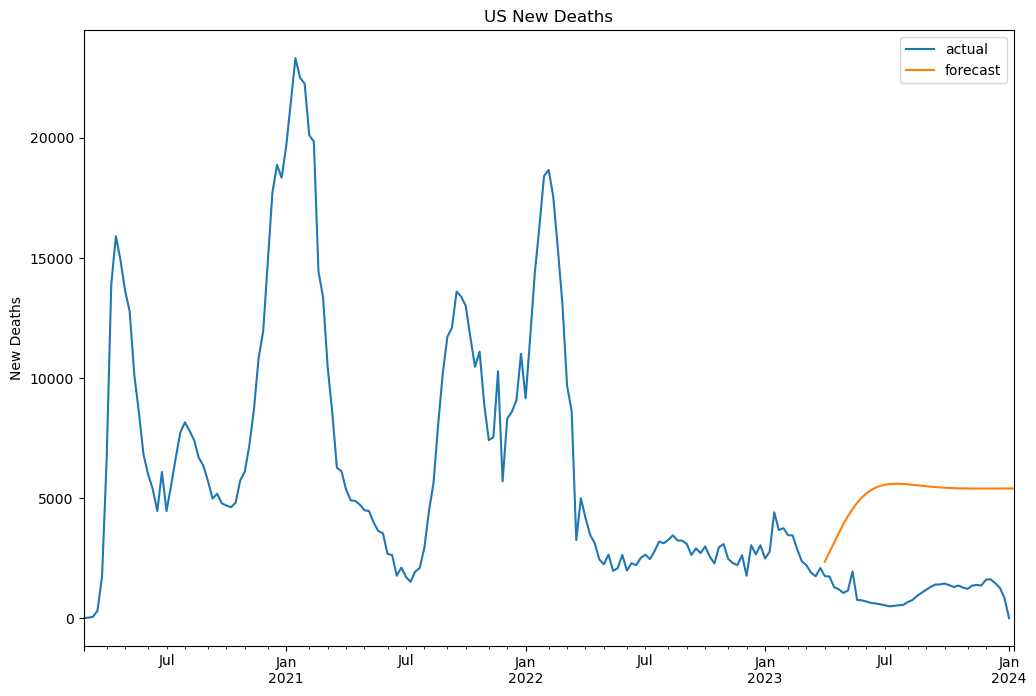

In [50]:
# tuned model 
p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(p, 1, q),seasonal_order=(P,1,Q,12))
modeL_fit=model.fit()
df['forecast'] = model_fit.predict(start=train_size, end=202, dynamic=True)
df.plot(figsize=(12,8))
# plot title and labels
plt.title('US New Deaths')
plt.ylabel('New Deaths')

In [ ]:
# import mae and mape
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error




